In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv


In [6]:
!pip install sentence-transformers faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.4 MB/s eta 0:00:00:00:0100:01


In [7]:
!nvidia-smi

Wed Aug  9 02:53:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import faiss
import numpy.linalg as la
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 50)
pd.set_option('max_colwidth', None)

# Load data

In [9]:
data = pd.read_csv('../input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv',memory_map=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [10]:
df = data[['Title','Plot']]

In [11]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['Plot'],inplace=True)
df.shape

(33869, 2)

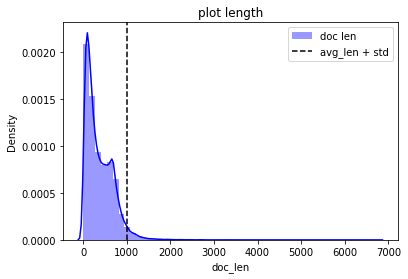

In [12]:
df['doc_len'] = df['Plot'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + 2*df['doc_len'].std()).astype(int)  # can use 2 * std
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='avg_len + std')
plt.title('plot length'); plt.legend()
plt.show()

In [13]:
max_seq_len = 256*3

# Given a text query, find similarity in Plots and give backs Titles

In [14]:
model = SentenceTransformer('msmarco-distilbert-base-tas-b')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [15]:
# encoded_data = model.encode(df.Plot.tolist(), batch_size=64, normalize_embeddings=True)
encoded_data = model.encode(df.Plot.tolist(), batch_size=32)
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(max_seq_len))  # how to choose Index scheme https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index
index.add_with_ids(encoded_data, np.array(range(len(df))))
faiss.write_index(index, 'movie_plot.index')  # To load the index from storage: index = faiss.read_index('movie_plot.index')

Batches:   0%|          | 0/1059 [00:00<?, ?it/s]

In [16]:
# Move the index to GPU for fast retrieval
res = faiss.StandardGpuResources()
index = faiss.index_cpu_to_gpu(res, 0, index)

In [17]:
query = 'Artificial Intelligence based action movie'
# query_emb = model.encode([query], normalize_embeddings=True).astype('float32')
query_emb = model.encode([query]).astype('float32')
print("Norm of query_emb: {}, shape: {}.\nValue of query_emb\n{}\n".format(la.norm(query_emb, 2), query_emb.shape, query_emb[0, :10]))
top_k = index.search(query_emb, 5)
print('Result from Faiss index search\n{}'.format(top_k))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Norm of query_emb: 11.054895401000977, shape: (1, 768).
Value of query_emb
[-0.1766696  -0.3214422   0.10062195  0.09684101  0.33834028 -0.05289602
  0.38484028 -0.18936217  0.0851839  -0.11888672]

Result from Faiss index search
(array([[97.56597 , 96.97875 , 96.53492 , 95.458885, 95.33414 ]],
      dtype=float32), array([[10292, 16674, 17175, 19688, 26254]]))


In [18]:
def fetch_movie_info(idx):
    return df.iloc[idx]

    
def search(query, top_k, index, model):
    """ Query result from Index
    query: string -> user typed query
    top_k: integer -> number of results to be returned
    index: faiss_index -> index to query the for results
    model: sbert -> model to encode the user-query
    """
    t=time.time()
    query_emb = model.encode([query], normalize_embeddings=True).astype('float32')
    top_k_res = index.search(query_emb, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_idx = top_k_res[1][0]
    results = fetch_movie_info(top_k_idx)
    return results

In [19]:
query = 'Love and relationships happened during the battle in Vietnam'
output = search(query, 10, index, model)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.057634592056274414


In [20]:
output

Title  \
23271     Bullet in the Head   
12000         Heaven & Earth   
6317          Jump into Hell   
9446           Big Wednesday   
3664     So Proudly We Hail!   
9315                  Tracks   
6000   Take the High Ground!   
8448             Hail, Hero!   
34654               Obsessed   
21423                  Noble   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## Retrain model with Synthetic query generation

In [21]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch


In [22]:
tokenizer = T5Tokenizer.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model = T5ForConditionalGeneration.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model.eval()

para = "The film is set in Vietnam in 1989, fourteen years after the end of the war. Christina Noble flies into Ho Chi Minh City (formerly Saigon), a country that she wouldn't be able to show you on a map. With a few dollars, her own hard-won courage, she is about embark on a life calling. The film explores her tough upbringing in Dublin and her early adult life in the UK. It is the inspirational true story of a woman who believes that it only takes one person to make a difference."

input_ids = tokenizer.encode(para, return_tensors='pt')
outputs = model.generate(
    input_ids=input_ids,
    max_length=32,
    do_sample=True,
    top_p=0.95,
    num_return_sequences=5)

print("Paragraph:")
print(para)

print("\nGenerated Queries:")
for i in range(len(outputs)):
    query = tokenizer.decode(outputs[i], skip_special_tokens=True)
    print(f'{i + 1}: {query}')

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.81k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.75G [00:00<?, ?B/s]

Paragraph:
The film is set in Vietnam in 1989, fourteen years after the end of the war. Christina Noble flies into Ho Chi Minh City (formerly Saigon), a country that she wouldn't be able to show you on a map. With a few dollars, her own hard-won courage, she is about embark on a life calling. The film explores her tough upbringing in Dublin and her early adult life in the UK. It is the inspirational true story of a woman who believes that it only takes one person to make a difference.

Generated Queries:
1: where was the film the woman who flew into vietnam set
2: where was christina noble filmed
3: how was the film christina noble
4: where is ho chi minh set
5: what is the naughtiest movie of the year


In [23]:
model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

para = "The film is set in Vietnam in 1989, fourteen years after the end of the war. Christina Noble flies into Ho Chi Minh City (formerly Saigon), a country that she wouldn't be able to show you on a map. With a few dollars, her own hard-won courage, she is about embark on a life calling. The film explores her tough upbringing in Dublin and her early adult life in the UK. It is the inspirational true story of a woman who believes that it only takes one person to make a difference."

input_ids = tokenizer.encode(para, return_tensors='pt')
outputs = model.generate(
    input_ids=input_ids,
    max_length=32,
    do_sample=True,
    top_p=0.95,
    num_return_sequences=5)

print("Paragraph:")
print(para)

print("\nGenerated Queries:")
for i in range(len(outputs)):
    query = tokenizer.decode(outputs[i], skip_special_tokens=True)
    print(f'{i + 1}: {query}')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Paragraph:
The film is set in Vietnam in 1989, fourteen years after the end of the war. Christina Noble flies into Ho Chi Minh City (formerly Saigon), a country that she wouldn't be able to show you on a map. With a few dollars, her own hard-won courage, she is about embark on a life calling. The film explores her tough upbringing in Dublin and her early adult life in the UK. It is the inspirational true story of a woman who believes that it only takes one person to make a difference.

Generated Queries:
1: Christina Noble takes a flight into Vietnam in 1989 - a country that you wouldn't see on a map. She shares personal courage
2: Christina Noble is about to embark on a life calling. takes place in Ho Chi Minh City, her earliest career in Ireland.
3: Christina Noble is driven by her incredible adventure to Ho Chi Minh City. The film is set in Vietnam in 1989.
4: Christina Noble is a young woman who wants to be a successful writer and journalist in the UK. With a few dollars, her own h

In [24]:
paragraphs = df.Plot.tolist()
len(paragraphs)

33869

In [25]:
device = 'cuda'
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [26]:
# Parameters for generation
batch_size = 16 #Batch size
num_queries = 1 #Number of queries to generate for every paragraph
max_length_paragraph = 512 #Max length for paragraph
max_length_query = 32   #Max length for output query

def _removeNonAscii(s):
    return "".join(i for i in s if ord(i) < 128)

with open('generated_queries_all.tsv', 'w') as fOut:
    for start_idx in tqdm(range(0, len(paragraphs), batch_size)):
        sub_paragraphs = paragraphs[start_idx:start_idx+batch_size]
        inputs = tokenizer.prepare_seq2seq_batch(sub_paragraphs, max_length=max_length_paragraph, truncation=True, return_tensors='pt').to(device)
        outputs = model.generate(
            **inputs,
            max_length=max_length_query,
            do_sample=True,
            top_p=0.95,
            num_return_sequences=num_queries)

        for idx, out in enumerate(outputs):
            query = tokenizer.decode(out, skip_special_tokens=True)
            query = _removeNonAscii(query)
            para = sub_paragraphs[int(idx/num_queries)]
            para = _removeNonAscii(para)
            fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

100%|██████████| 2117/2117 [48:45<00:00,  1.38s/it]


In [27]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os
import random

train_examples = [] 
with open('generated_queries_all.tsv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples.append(InputExample(texts=[query, paragraph]))
        except:
            pass
        
random.shuffle(train_examples)

# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)

# Now we create a SentenceTransformer model from scratch
word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-tas-b')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])


# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(model)


#Tune the model
num_epochs = 3
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)

os.makedirs('search', exist_ok=True)
model.save('search/search-model')

Downloading:   0%|          | 0.00/548 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4233 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4233 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4233 [00:00<?, ?it/s]

In [28]:
# from sentence_transformers import util
# import gzip
# import json
# import os

# model = SentenceTransformer('search/search-model')
# !zip -r search_model.zip "./search"

In [29]:
encoded_data = model.encode(df.Plot.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(len(df))))
faiss.write_index(index, 'movie_plot_tuned.index')

Batches:   0%|          | 0/1059 [00:00<?, ?it/s]

In [30]:
query = 'Love and relationships happened during the battle in Vietnam'
output = search(query, 10, index, model)
output

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.09345722198486328


Title  \
14114          Path to War   
34787         Just for You   
15175           Chicago 10   
9168            Milestones   
3664   So Proudly We Hail!   
8448           Hail, Hero!   
12998    Going All the Way   
34374          White Badge   
10721       Hamburger Hill   
2607   Lady of the Tropics   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          